<a href="https://colab.research.google.com/github/movindugunarathna/sinXdetect/blob/main/ml/bert_text_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install Required Libraries

In [1]:
%pip install -q tf-keras
%pip install -q transformers
%pip install -q datasets
%pip install -q nltk
%pip install -q scikit-learn
%pip install -q matplotlib

## 2. Import Required Libraries

In [2]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

# Suppress TensorFlow deprecation warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

## 3. Load Dataset from JSONL Files

In [3]:
import os
import json
import gdown

# URL of the dataset folder
url = 'https://drive.google.com/drive/folders/1TbQbDcHKhVurAJIOekhXysMrc1JpBpyg?usp=sharing'
output_folder = 'dataset'

# Download the folder from Google Drive if it doesn't exist
if not os.path.exists(output_folder):
    print("Downloading dataset...")
    gdown.download_folder(url, output=output_folder, quiet=False, use_cookies=False)

def load_jsonl(filepath):
    """Load data from JSONL file"""
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return data

# Load training, validation, and test datasets
# Assuming the files are named train.jsonl, val.jsonl, and test.jsonl inside the folder
train_data = load_jsonl(os.path.join(output_folder, 'train.jsonl'))
val_data = load_jsonl(os.path.join(output_folder, 'val.jsonl'))
test_data = load_jsonl(os.path.join(output_folder, 'test.jsonl'))

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Testing set size: {len(test_data)}")

Retrieving folder contents


Processing file 1G3PA1UqNWoYnJiu5kDSEIOae49S-z1cF test.jsonl
Processing file 19zYKgEld03P3C_1SLH_5bTcx4Wix0a93 train.jsonl
Processing file 1SF0epR8kgAgdRdd_UYIiaGQAteEs9Hur val.jsonl


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1G3PA1UqNWoYnJiu5kDSEIOae49S-z1cF
To: /content/dataset/test.jsonl
100%|██████████| 38.7M/38.7M [00:00<00:00, 162MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=19zYKgEld03P3C_1SLH_5bTcx4Wix0a93
From (redirected): https://drive.google.com/uc?id=19zYKgEld03P3C_1SLH_5bTcx4Wix0a93&confirm=t&uuid=61ea2e77-ab58-40f5-b139-4d948e28dfbd
To: /content/dataset/train.jsonl
100%|██████████| 180M/180M [00:01<00:00, 177MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SF0epR8kgAgdRdd_UYIiaGQAteEs9Hur
To: /content/dataset/val.jsonl
100%|██████████| 21.7M/21.7M [00:00<00:00, 130MB/s] 
Download completed


Training set size: 77788
Validation set size: 9045
Testing set size: 13046


## 4. Convert JSONL to DataFrame and Preprocess

In [4]:
# Convert to DataFrame
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

# Display sample data
print("Sample training data:")
print(train_df[['text', 'label']].head())
print(f"\nLabel value counts (Train):")
print(train_df['label'].value_counts())

Sample training data:
                                                text  label
0  ප්‍රකට කවියෙකු වන [කවියාගේ නම] ගේ නවතම කාව්‍ය ...     AI
1  ශ්‍රී ලංකා රජය දෙමළ සංවිධාන හයකට පනවා තිබූ තහන...     AI
2  (අමදෝරු අමරජීව) රාජ්‍ය සේවා තරග විභාගයකදී වංචා...  HUMAN
3  (ප්‍රින්ස් රත්නායක)ශ්‍රී ලංකා සබරගමුව විශ්වවිද...  HUMAN
4  (ඩී.ජී.සුගතපාල)දඩල්ල මුහුදු වෙරලට පැමිණෙන පෙම්...  HUMAN

Label value counts (Train):
label
HUMAN    39848
AI       37940
Name: count, dtype: int64


## 5. Map Labels to Numeric Values

In [5]:
# Create label mapping
label_mapping = {'HUMAN': 0, 'AI': 1}
reverse_mapping = {v: k for k, v in label_mapping.items()}

# Map labels to numeric values
train_df['label_encoded'] = train_df['label'].map(label_mapping)
val_df['label_encoded'] = val_df['label'].map(label_mapping)
test_df['label_encoded'] = test_df['label'].map(label_mapping)

# Check for any unmapped values
print(f"Train - Unmapped labels: {train_df['label_encoded'].isna().sum()}")
print(f"Val - Unmapped labels: {val_df['label_encoded'].isna().sum()}")
print(f"Test - Unmapped labels: {test_df['label_encoded'].isna().sum()}")

Train - Unmapped labels: 0
Val - Unmapped labels: 0
Test - Unmapped labels: 0


## 6. Text Preprocessing

In [6]:
import unicodedata

# Sinhala-focused normalization & contraction expansion

def expand_contractions(text):
    """
    Normalize Sinhala text and expand a small set of common colloquial contractions.
    - NFC Unicode normalization (avoids mixed composition forms)
    - Remove Zero-Width Joiner/Non-Joiner which can appear in Sinhala typing
    - Expand a curated list of common colloquial forms to their standard forms
    Note: This list is intentionally conservative to avoid changing semantics.
    """
    if not isinstance(text, str):
        return text

    # Normalize to NFC to standardize diacritics
    text = unicodedata.normalize('NFC', text)

    # Remove zero-width characters often accidentally present
    text = text.replace('\u200c', '').replace('\u200d', '')  # ZWNJ/ZWJ

    # Conservative Sinhala "contractions" / colloquial expansions
    contractions_si = {
        # Negation forms
        'නෑ': 'නැහැ',
        'බෑ': 'බැහැ',
        # Colloquial vowels / emphasis
        'දැං': 'දැන්',
        'කොහේද': 'කොහෙද',
        'මොකෝ': 'මොකද',
        # Common short forms ending with "ෙ" to "ේ" (targeted words only)
        'ඇතුලෙ': 'ඇතුලේ',
        'බාහිරෙ': 'බාහිරේ',
        'වැඩෙ': 'වැඩේ',
        'රජයෙ': 'රජයේ',
        'යාලුවෙ': 'යාලුවේ',
    }

    # Apply word-boundary replacements for items above
    for contraction, expanded in contractions_si.items():
        text = re.sub(r"\b" + re.escape(contraction) + r"\b", expanded, text)

    # Targeted possessive expansions (avoid generic "ගෙ" → "ගේ" to not corrupt 'ගෙදර')
    text = re.sub(r"\bමගෙ\b", "මගේ", text)
    text = re.sub(r"\bඔයාගෙ\b", "ඔයාගේ", text)
    text = re.sub(r"\bඔගෙ\b", "ඔගේ", text)

    return text

# Apply expansion of contractions using Sinhala-focused normalization
print("Preprocessing training data (Sinhala normalization)...")
train_df['expanded_text'] = train_df['text'].apply(expand_contractions)

print("Preprocessing validation data (Sinhala normalization)...")
val_df['expanded_text'] = val_df['text'].apply(expand_contractions)

print("Preprocessing test data (Sinhala normalization)...")
test_df['expanded_text'] = test_df['text'].apply(expand_contractions)

print("Preprocessing complete!")

Preprocessing training data (Sinhala normalization)...
Preprocessing validation data (Sinhala normalization)...
Preprocessing test data (Sinhala normalization)...
Preprocessing complete!


## 7. Load BERT Tokenizer

In [7]:
# Load MobileBERT tokenizer (very lightweight model, ~150MB, supports multilingual)
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('google/mobilebert-uncased')
print("MobileBERT tokenizer loaded successfully!")

config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

MobileBERT tokenizer loaded successfully!


## 8. Tokenize and Encode Text Data

In [8]:
# Tokenize and encode the text data using tokenizer in batches to avoid memory spikes
print("Tokenizing data in batches...")

def tokenize_in_batches(texts, tokenizer, batch_size=32, max_length=512):
    """Tokenize a list of texts in small batches and return numpy arrays.
    Returns a dict with 'input_ids' and 'attention_mask' as numpy arrays.
    Pads every batch to `max_length` so concatenation shapes match.
    """
    input_ids_parts = []
    attention_mask_parts = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(
            batch,
            padding='max_length',   # pad each batch to the fixed max_length
            truncation=True,
            max_length=max_length,
            return_tensors='tf'
        )
        # Convert to numpy to keep memory usage predictable and avoid nested lists
        ids = enc['input_ids'].numpy()
        mask = enc['attention_mask'].numpy()

        # Sanity check: ensure shape[1] == max_length
        if ids.shape[1] != max_length:
            # If tokenizer produced a different length for some reason, force-pad/truncate
            ids = np.pad(ids, ((0,0),(0,max_length-ids.shape[1])), constant_values=0)[:,:max_length]
            mask = np.pad(mask, ((0,0),(0,max_length-mask.shape[1])), constant_values=0)[:,:max_length]

        input_ids_parts.append(ids)
        attention_mask_parts.append(mask)

    input_ids = np.concatenate(input_ids_parts, axis=0)
    attention_mask = np.concatenate(attention_mask_parts, axis=0)

    return {'input_ids': input_ids, 'attention_mask': attention_mask}

# Run batched tokenization
train_encodings = tokenize_in_batches(train_df['expanded_text'].tolist(), tokenizer, batch_size=32)
val_encodings = tokenize_in_batches(val_df['expanded_text'].tolist(), tokenizer, batch_size=32)
test_encodings = tokenize_in_batches(test_df['expanded_text'].tolist(), tokenizer, batch_size=32)

print("Tokenization complete!")
print(f"Training encodings shape: {train_encodings['input_ids'].shape}")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Tokenizing data in batches...
Tokenization complete!
Training encodings shape: (77788, 512)


## 9. Prepare Labels

In [9]:
# Extract input arrays and convert labels to numpy arrays
# Use dicts with both input_ids and attention_mask so the model gets both inputs
train_inputs = {
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask']
}
val_inputs = {
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask']
}
test_inputs = {
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask']
}

# Convert labels to numpy arrays
train_labels = np.array(train_df['label_encoded'].astype(int).tolist())
val_labels = np.array(val_df['label_encoded'].astype(int).tolist())
test_labels = np.array(test_df['label_encoded'].astype(int).tolist())

print(f"Train labels shape: {train_labels.shape}")
print(f"Val labels shape: {val_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"\nLabel distribution (Train): {np.bincount(train_labels)}")
print(f"Label distribution (Val): {np.bincount(val_labels)}")
print(f"Label distribution (Test): {np.bincount(test_labels)}")

Train labels shape: (77788,)
Val labels shape: (9045,)
Test labels shape: (13046,)

Label distribution (Train): [39848 37940]
Label distribution (Val): [4981 4064]
Label distribution (Test): [6981 6065]


## 10. Define BERT Classification Model

In [10]:
# Load pre-trained MobileBERT model for sequence classification (very lightweight, ~150MB)
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    'google/mobilebert-uncased',
    num_labels=2  # Binary classification: HUMAN (0) vs AI (1)
)

print("MobileBERT model loaded successfully!")

tf_model.h5:   0%|          | 0.00/164M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFMobileBertForSequenceClassification.

Some layers of TFMobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MobileBERT model loaded successfully!


## 11. Compile the Model

In [11]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[metric]
)

print("Model compiled successfully!")
print("\nModel Summary:")
model.summary()

Model compiled successfully!

Model Summary:
Model: "tf_mobile_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilebert (TFMobileBertMa  multiple                  24581888  
 inLayer)                                                        
                                                                 
 dropout_49 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1026      
                                                                 
Total params: 24582914 (93.78 MB)
Trainable params: 24582914 (93.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 12. Train the BERT Model

In [12]:
# Train the BERT model
print("Training the model...")
history = model.fit(
    train_inputs,
    train_labels,
    epochs=3,  # Reduced epochs due to large dataset size
    batch_size=16,
    validation_data=(val_inputs, val_labels),
    verbose=1
)

print("\nTraining completed!")

Training the model...
Epoch 1/3
4862/4862 [==============================] - 1580s 263ms/step - loss: 962.5353 - accuracy: 0.7709 - val_loss: 1.2565 - val_accuracy: 0.9150
Epoch 2/3
4862/4862 [==============================] - 1258s 259ms/step - loss: 0.4339 - accuracy: 0.9286 - val_loss: 0.1540 - val_accuracy: 0.9399
Epoch 3/3
4862/4862 [==============================] - 1259s 259ms/step - loss: 0.1060 - accuracy: 0.9607 - val_loss: 0.0753 - val_accuracy: 0.9735

Training completed!


## 13. Save the Trained Model

In [13]:
# Save the entire trained model
model.save_pretrained("models/bert_multilingual/")
print("Model saved to models/bert_multilingual/")

# Also save the tokenizer
tokenizer.save_pretrained("models/bert_multilingual/")
print("Tokenizer saved to models/bert_multilingual/")

Model saved to models/bert_multilingual/
Tokenizer saved to models/bert_multilingual/


## 14. Evaluate on Validation Set

In [14]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_inputs, val_labels, verbose=0)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Loss: 0.0753
Validation Accuracy: 0.9735


## 15. Evaluate on Test Set

In [15]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_inputs, test_labels, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.9689
Test Accuracy: 0.7818


## 16. Plot Training and Validation Accuracy

FileNotFoundError: [Errno 2] No such file or directory: 'results/training_history.png'

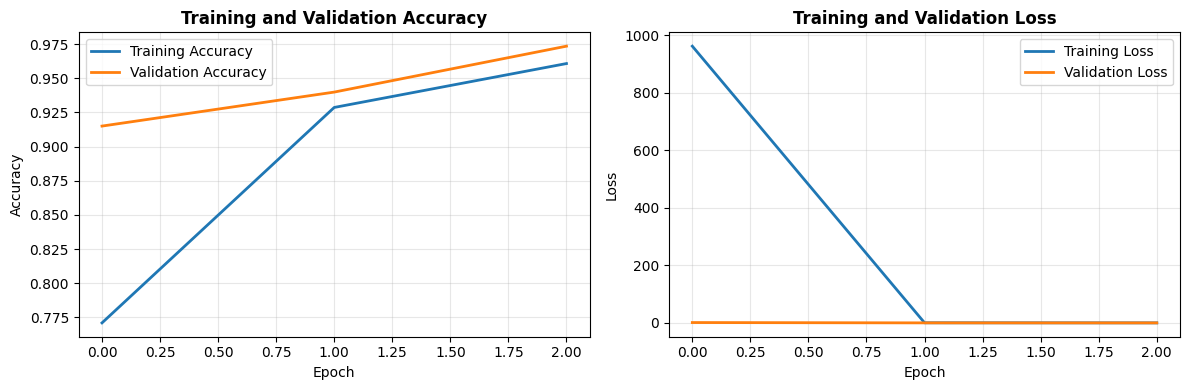

In [16]:
# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_history.png', dpi=100, bbox_inches='tight')
plt.show()

print("Training history plot saved!")

## 17. Generate Predictions and Confusion Matrix

408/408 [==============================] - 72s 144ms/step


FileNotFoundError: [Errno 2] No such file or directory: 'results/confusion_matrix.png'

<Figure size 800x600 with 0 Axes>

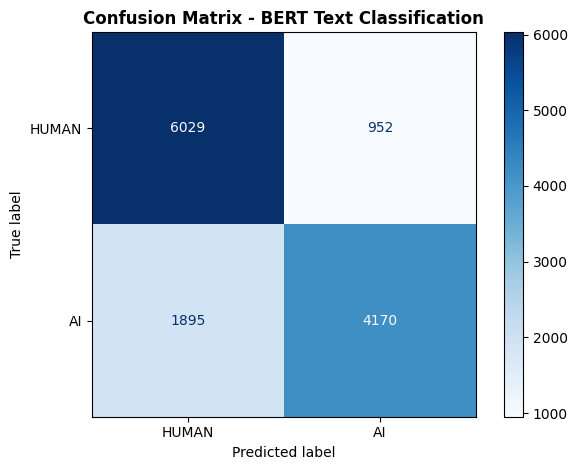

In [17]:
# Predict labels for the test set
predictions = model.predict(test_inputs)
predicted_labels = np.argmax(predictions.logits, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Display confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['HUMAN', 'AI'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - BERT Text Classification', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('results/confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

print("Confusion matrix saved!")

## 18. Calculate ROC Curve and AUC Score

FileNotFoundError: [Errno 2] No such file or directory: 'results/roc_curve.png'

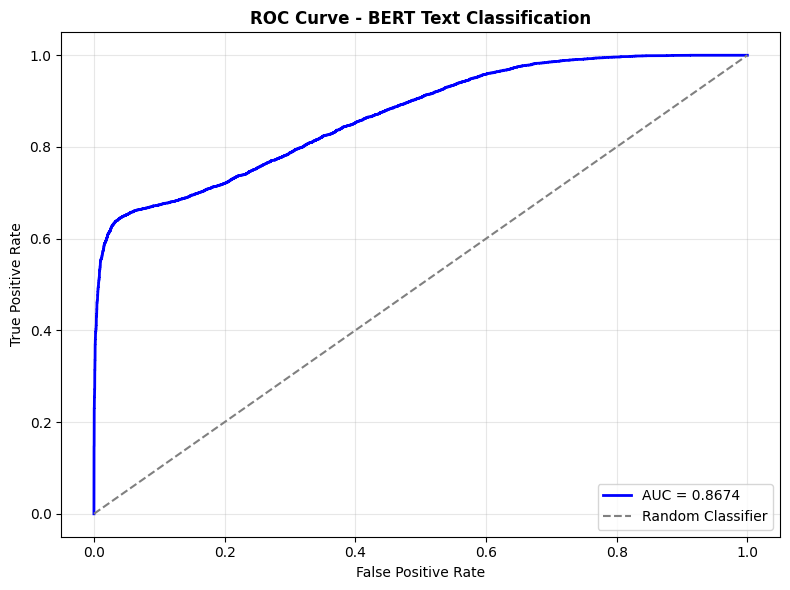

In [18]:
# Get probabilities for positive class (AI)
probabilities = tf.nn.softmax(predictions.logits)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(test_labels, probabilities)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', linewidth=2, color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - BERT Text Classification', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/roc_curve.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"AUC Score: {auc_score:.4f}")

## 19. Classification Report

In [19]:
# Generate detailed classification report
report = classification_report(
    test_labels,
    predicted_labels,
    target_names=['HUMAN', 'AI'],
    digits=4
)

print("\n" + "="*60)
print("CLASSIFICATION REPORT - TEST SET")
print("="*60)
print(report)
print("="*60)


CLASSIFICATION REPORT - TEST SET
              precision    recall  f1-score   support

       HUMAN     0.7609    0.8636    0.8090      6981
          AI     0.8141    0.6876    0.7455      6065

    accuracy                         0.7818     13046
   macro avg     0.7875    0.7756    0.7772     13046
weighted avg     0.7856    0.7818    0.7795     13046



## 20. Summary of Model Performance

In [20]:
# Create a summary of model performance
summary_data = {
    'Metric': ['Test Accuracy', 'Test Loss', 'AUC Score'],
    'Value': [f'{test_accuracy:.4f}', f'{test_loss:.4f}', f'{auc_score:.4f}']
}

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*50)
print("MODEL PERFORMANCE SUMMARY")
print("="*50)
print(summary_df.to_string(index=False))
print("="*50)

# Save summary
summary_df.to_csv('results/model_performance_summary.csv', index=False)
print("\nPerformance summary saved to results/model_performance_summary.csv")


MODEL PERFORMANCE SUMMARY
       Metric  Value
Test Accuracy 0.7818
    Test Loss 0.9689
    AUC Score 0.8674


OSError: Cannot save file into a non-existent directory: 'results'

In [21]:
from sklearn.metrics import f1_score, average_precision_score

# Define constants used in training (based on previous cells)
MODEL_NAME = "google/mobilebert-uncased"
MAX_LENGTH = 512
EPOCHS = 3
TRAIN_BATCH_SIZE = 16
LEARNING_RATE = 2e-5
MODEL_SAVE_PATH = "models/bert_multilingual/"

# Calculate additional metrics needed for the summary
f1 = f1_score(test_labels, predicted_labels)
avg_precision = average_precision_score(test_labels, probabilities)
accuracy = test_accuracy

# Final summary
print("\n" + "="*70)
print("mBERT SINHALA CLASSIFIER - FINAL SUMMARY")
print("="*70)
print(f"\nModel: {MODEL_NAME}")
print(f"Parameters: {model.count_params():,}")
print(f"Max Sequence Length: {MAX_LENGTH}")
print(f"\nDataset Sizes:")
print(f"  Training: {len(train_df):,} samples")
print(f"  Validation: {len(val_df):,} samples")
print(f"  Test: {len(test_df):,} samples")
print(f"\nTraining Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {TRAIN_BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"\nPerformance:")
print(f"  Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  AUC Score: {auc_score:.4f}")
print(f"  Average Precision: {avg_precision:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"\nModel saved to: {MODEL_SAVE_PATH}")
print("="*70)

print("\n✓ All tasks completed successfully!")


mBERT SINHALA CLASSIFIER - FINAL SUMMARY

Model: google/mobilebert-uncased
Parameters: 24,582,914
Max Sequence Length: 512

Dataset Sizes:
  Training: 77,788 samples
  Validation: 9,045 samples
  Test: 13,046 samples

Training Configuration:
  Epochs: 3
  Batch Size: 16
  Learning Rate: 2e-05

Performance:
  Test Accuracy: 0.7818 (78.18%)
  Test Loss: 0.9689
  AUC Score: 0.8674
  Average Precision: 0.8819
  F1-Score: 0.7455

Model saved to: models/bert_multilingual/

✓ All tasks completed successfully!


In [ ]:
from sklearn.metrics import f1_score, average_precision_score

# Define constants used in training (based on previous cells)
MODEL_NAME = "google/mobilebert-uncased"
MAX_LENGTH = 512
EPOCHS = 3
TRAIN_BATCH_SIZE = 16
LEARNING_RATE = 2e-5
MODEL_SAVE_PATH = "models/bert_multilingual/"

# Calculate additional metrics needed for the summary
f1 = f1_score(test_labels, predicted_labels)
avg_precision = average_precision_score(test_labels, probabilities)
accuracy = test_accuracy

# Final summary
print("\n" + "="*70)
print("mBERT SINHALA CLASSIFIER - FINAL SUMMARY")
print("="*70)
print(f"\nModel: {MODEL_NAME}")
print(f"Parameters: {model.count_params():,}")
print(f"Max Sequence Length: {MAX_LENGTH}")
print(f"\nDataset Sizes:")
print(f"  Training: {len(train_df):,} samples")
print(f"  Validation: {len(val_df):,} samples")
print(f"  Test: {len(test_df):,} samples")
print(f"\nTraining Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {TRAIN_BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"\nPerformance:")
print(f"  Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  AUC Score: {auc_score:.4f}")
print(f"  Average Precision: {avg_precision:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"\nModel saved to: {MODEL_SAVE_PATH}")
print("="*70)

print("\n✓ All tasks completed successfully!")


mBERT SINHALA CLASSIFIER - FINAL SUMMARY

Model: google/mobilebert-uncased
Parameters: 24,582,914
Max Sequence Length: 512

Dataset Sizes:
  Training: 77,788 samples
  Validation: 9,045 samples
  Test: 13,046 samples

Training Configuration:
  Epochs: 3
  Batch Size: 16
  Learning Rate: 2e-05

Performance:
  Test Accuracy: 0.7818 (78.18%)
  Test Loss: 0.9689
  AUC Score: 0.8674
  Average Precision: 0.8819
  F1-Score: 0.7455

Model saved to: models/bert_multilingual/

✓ All tasks completed successfully!


In [ ]:
from sklearn.metrics import f1_score, average_precision_score

# Define constants used in training (based on previous cells)
MODEL_NAME = "google/mobilebert-uncased"
MAX_LENGTH = 512
EPOCHS = 3
TRAIN_BATCH_SIZE = 16
LEARNING_RATE = 2e-5
MODEL_SAVE_PATH = "models/bert_multilingual/"

# Calculate additional metrics needed for the summary
f1 = f1_score(test_labels, predicted_labels)
avg_precision = average_precision_score(test_labels, probabilities)
accuracy = test_accuracy

# Final summary
print("\n" + "="*70)
print("mBERT SINHALA CLASSIFIER - FINAL SUMMARY")
print("="*70)
print(f"\nModel: {MODEL_NAME}")
print(f"Parameters: {model.count_params():,}")
print(f"Max Sequence Length: {MAX_LENGTH}")
print(f"\nDataset Sizes:")
print(f"  Training: {len(train_df):,} samples")
print(f"  Validation: {len(val_df):,} samples")
print(f"  Test: {len(test_df):,} samples")
print(f"\nTraining Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {TRAIN_BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"\nPerformance:")
print(f"  Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  AUC Score: {auc_score:.4f}")
print(f"  Average Precision: {avg_precision:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"\nModel saved to: {MODEL_SAVE_PATH}")
print("="*70)

print("\n✓ All tasks completed successfully!")


mBERT SINHALA CLASSIFIER - FINAL SUMMARY

Model: google/mobilebert-uncased
Parameters: 24,582,914
Max Sequence Length: 512

Dataset Sizes:
  Training: 77,788 samples
  Validation: 9,045 samples
  Test: 13,046 samples

Training Configuration:
  Epochs: 3
  Batch Size: 16
  Learning Rate: 2e-05

Performance:
  Test Accuracy: 0.7818 (78.18%)
  Test Loss: 0.9689
  AUC Score: 0.8674
  Average Precision: 0.8819
  F1-Score: 0.7455

Model saved to: models/bert_multilingual/

✓ All tasks completed successfully!


In [22]:
import shutil
from google.colab import files

# Define the folder to zip and the output filename
folder_path = 'models/bert_multilingual/'
zip_filename = 'bert_multilingual'

# Create a zip archive
shutil.make_archive(zip_filename, 'zip', folder_path)
print(f"Created zip file: {zip_filename}.zip")

# Download the zip file
files.download(f'{zip_filename}.zip')

Created zip file: bert_multilingual.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>